In [ ]:
#please make sure you have the following libraries installed before continuing running this notebook
#pip install tensorflow
#keras needs tensorflow or other backends as caffe or theano
#pip install keras

Download the Glove text word vector file here: https://www.dropbox.com/s/my83b23ev2h9qgp/glove.6B.50d.txt?dl=1
After downloading please place it in the directory same as that of this notebook or give appropriate path.

Framing Sentiment analysis as a deep Learning Problem
1) Training a word vector generation model (such as Word2Vec) or loading pretrained word vectors
2) Creating an ID's matrix for our training set (We'll discuss this a bit later)
3) RNN (With LSTM units) graph creation
4) Training 
5) Testing


Also, we use Glove vector generation model for word2vec embeddings here.
We're going to be importing two different data structures, one will be a Python list with the 400,000 words, and one will be a 400,000 x 50 dimensional embedding matrix that holds all of the word vector values.

In [1]:
import numpy as np
import pandas as pd

In [4]:
yelp = pd.read_csv('https://raw.githubusercontent.com/shrikumarp/shrikumarpp1/master/yelp.csv', usecols = ["stars", "text"])

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

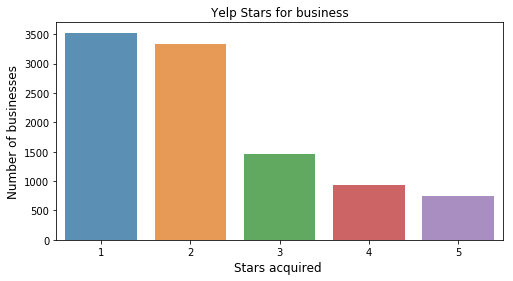

In [4]:
x=yelp['stars'].value_counts()
y=x.sort_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars for business")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Stars acquired ', fontsize=12);
#counting the number of reviews for each of the rating level available to the reviewers.

In [5]:
yelp["labels"]= yelp["stars"].apply(lambda x: 1 if x >= 3  else 0)
yelp=yelp.drop("stars",axis=1)

yelp.head()

,text,labels
0,My wife took me here on my birthday for breakf...,1
1,I have no idea why some people give bad review...,1
2,love the gyro plate. Rice is so good and I als...,1
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1
4,General Manager Scott Petello is a good egg!!!...,1


In [6]:
MAX_NUM_WORDS=1000
MAX_SEQUENCE_LENGTH=100

The MAX_NUM_WORDS value means the number of unique rows to be used in the embedding vector, which coreesponds to the number of unique words to be used. The MAX_SEQUENCE_LENGTH value means the maximum length of a review to use, means the maximum number of words to be taken from a certain review sentence.

Now we need to preprocess the text data in integerized word vectors using the Glove word vectors so that we can give that input to our LSTM neural network. The first step in preprocessing will be tokenization, which will seperate each unique words from the sentence, and we will use pad_sequences to pad the sentences to the maximum sequence length MAX_SEQUENCE_LENGTH defined above.

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [8]:
texts = yelp["text"].values
labels = yelp["labels"].values

In [9]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts) # fit the tokenizer on the review text column
sequences = tokenizer.texts_to_sequences(texts) #text to sequence transformation

In [10]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 30816 unique tokens.


In [11]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [12]:
from keras.utils import to_categorical

In [13]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (10000, 100)
Shape of label tensor: (10000, 2)


In [14]:
VALIDATION_SPLIT=0.2 # we take 20% of the data as validation set.

In [15]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices) # randomly shuffle indices to increase diversity in the training set.
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [16]:
# spliting into training and testing set.
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [17]:
GLOVE_DIR='../input/glove-global-vectors-for-word-representation/'

Here, we use the glove

In [20]:
import os
embeddings_index = {}
f = open(os.path.join('glove.6B.50d.txt'), encoding = "utf8")

#if you are on a windows machine please use the line below and comment out the above line as we need to provide the path reference in windows.
#f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding = "utf8")
# download the glove zip from - https://nlp.stanford.edu/projects/glove/
#and put it in the directory of this notebook.
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# the above for loop iterates along every word and its corresponding vector given in the Glove text file, 
#and creates a dictionary with the key as the word and the value as the corresponding  integerized word vector. 

In [21]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [22]:
EMBEDDING_DIM = 50

As we have specified the EMBEDDING_DIM value as 50, and we have found 400000 word vectors, the dimensions of our embedding matrix will be 400000 x 50.

Now the for loop in the next block of code will take each of the word from the unique words collections of word_index which we defined before from out review texts, and search for the corresponding word vector from the embeddings index dictionary.
Now we will put each of the retrieved embedding vector in the embedding matrix, which will be passed as an input to out embedding layer.

In [23]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [24]:
from keras.layers import Embedding

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)

Now as above we have set the sequence length as 100 for each sequence and the output dimensions as 50, we will get a sequence vector of dimension 100 x 50 for each of the 100 words in sequence.

In [26]:
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D

In [27]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

In [28]:
from keras.models import Model

In [29]:
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
# as we have set the output dimensions of the embedding layer as 50, we set the input neurons of the first LSTM layer succeding that as 50.
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#The pooling layer serves to progressively reduce the spatial size of the representation, to reduce the number of 
#parameters and amount of computation in the network, and hence to also control overfitting. 
#It is common to periodically insert a pooling layer between successive convolutional layers in a CNN architecture.
#The pooling operation provides another form of translation invariance.

We use Binary Crossentropy because we are dealing with binary classification problem here, we chose the activation functions as rectified Linear and Sigmoid for the layers.

In [30]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=128);

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - 16s 2ms/step - loss: 0.4538 - acc: 0.8287 - val_loss: 0.4463 - val_acc: 0.8125
Epoch 2/2
8000/8000 [==============================] - 14s 2ms/step - loss: 0.3915 - acc: 0.8380 - val_loss: 0.3836 - val_acc: 0.8195


In [32]:
score, acc = model.evaluate(x_val, y_val,
                            batch_size=32,
                            verbose=2)
print('Test accuracy:', acc)

Test accuracy: 0.8195


Some code snippets have been referenced from:
https://github.com/adeshpande3/LSTM-Sentiment-Analysis/blob/master/Oriole%20LSTM.ipynb
by Adit Deshpande is licensed under the MIT License https://opensource.org/licenses/MIT.


https://www.kaggle.com/poonaml/bidirectional-lstm-spacy-on-yelp-reviews/notebook
open sourced public blog on kaggle.com